# Laboratory 4: Getting started with Pytorch

In this laboratory we will begin working with Pytorch to implement and train complex, nonlinear models for supervised learning problems. You will notice many similarities between Numpy and Pytorch -- this is deliberate, but it can cause some confusion and for many things we will have to convert back and forth between Numpy arrays and Pytorch tensors.

## Part 0: First steps

**Important**: You **must** install Pytorch in your Anaconda environment for this laboratory. The easiest way to do this is to just install the CPU version of Pytorch like this:

```
conda activate FML
conda install -c pytorch pytorch torchvision
```

**Note**: If you have an Nvidia GPU on your computer you can also install the GPU-enabled version of Pytorch which will **greatly** improve performance for more complex models and larger datasets. However, it can be very hard to get all of the versions of the required libraries to match correctly... During the laboratory we can look at it together if you are interested.

After installing Pytorch, use the next cell to verify that the installation is working. If it prints a 3x3 sensor, we're good to go.

In [1]:
# We're still going to need numpy and matplotlib.
import numpy as np
import matplotlib.pyplot as plt

# Verify that pytorch is working.
import torch

foo = torch.randn((3, 3))
print(foo)

tensor([[-0.3529,  0.0764,  0.1721],
        [ 0.4115,  0.2378,  0.7041],
        [-1.4727, -1.3554,  0.8263]])


## Part 1: Dataset preparation

We will work with the venerable MNIST dataset of handwritten digits in this laboratory. The `torchvision` library provides classes for a bunch of standard datasets, including MNIST. These classes automatically download and prepare the dataset for use.

In [20]:
# Download and load the MNIST dataset.
from torchvision.datasets import MNIST
import torchvision

# Load the MNIST training and test splits.
ds_train = MNIST(root='./data', download=True, train=True)
ds_test  = MNIST(root='./data', download=True, train=False)

### Exercise 1.1: Exploratory data analysis

Spend some time inspecting the `ds_train` and `ds_test` data structures in order to get a feel for the data. What is the format? How big are the images? How many are there? What about the range of pixel values? Where are the labels for images?

Remember that one of the best ways to explore is to *visualize*.

In [21]:
# training dataset is made of 60.000 datapoints and 10.000 datapoints for testing
# images are 28×28 pixel grayscale images in range between 0 and 255 including bounding values
# labels for images are the class that they belong to

display = False
print(ds_train.data.shape)
print(ds_test.data.shape)
plt.figure(figsize = (10, 10))
if display:
    for i in range (100):
        plt.subplot(10, 10, i+1)
        plt.imshow(ds_train.data[i], cmap = 'gray')
        plt.axis('off')

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


<Figure size 1000x1000 with 0 Axes>

### Exercise 1.2: Dataset conversion and normalization

+ **Datatype Conversion**:
The first thing we need to do is convert all data tensors to `torch.float32` -- this is fundamental as it is extremely inconvenient to work with `uint8` data. Using 32-bit floating point numbers is a compromise between precision and space efficiency.
The `torch.Tensor` class has a very useful method `to()` for performing datatype and device (e.g. to GPU) conversions. Check out the [documentation here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to).

+ **Normalization**:
Next, we need to correct the inconvenient range of [0, 255] for the pixel values. You should *subtract* the mean intensity value and divide by the standard deviation in order to *standardize* our data. **Important**: Think *very carefully* about *which* split you should use to compute the pixel statistics for standardization.

+ **Reshaping**: Is the data in an appropriate format (i.e. shape) for the training the models we know? Think about whether (and how) to fix this if needed. 

**What to do**: In the cell below you should perform this sequence preprocessing operations on the `ds_train.data` and `ds_test.data` tensors. 

In [22]:
# data conversion
ds_train.data = ds_train.data.to(torch.float32)
ds_test.data  = ds_test.data.to(torch.float32)
# calculating mean and standard deviation
# computing on train split because it will be the one that we base our model on
mean = ds_train.data.mean()
std  = ds_train.data.std()
ds_train.data = (ds_train.data - mean) / std
ds_test.data = (ds_test.data - mean) / std
# reshaping on 60.000 datapoints
#ds_train.data = ds_train.data.flatten(-1, 1)
# we can see how the shape changes into a single 784 array for each datapoint
#print(ds_train.data.shape)

### Exercise 1.3: Subsampling the MNIST dataset.

MNIST is kind of big, and thus inconvenient to work with unless using the GPU. For this laboratory we will use a smaller subset of the dataset for training to keep memory and computation times low.

Modify `ds.train` to use only a subset of, say, 10000 images sampled from the original data. Make sure to select the correct corresponding targets.


In [23]:
import copy

train_size = 10000
val_size = 2000
I = np.random.permutation(len(ds_train.data))

# validation set
ds_val = copy.deepcopy(ds_train)
ds_val.data = ds_val.data[I[train_size:(train_size+val_size)]].flatten(1, 2)
ds_val.targets = ds_val.targets[I[train_size:(train_size+val_size)]]
print('Validation set shape', ds_val.data.shape)

# train set
print('Train before reshaping', ds_train.data.shape)
ds_train.data = ds_train.data[I[:train_size]].flatten(1, 2)
print('Train after reshaping', ds_train.data.shape)
ds_train.targets = ds_train.targets[I[:train_size]]

# test set
print('Test before reshaping', ds_test.data.shape)
ds_test.data = ds_test.data.flatten(1, 2)
print('Test after reshaping',ds_test.data.shape)

# CAN BE EXECUTED ONLY ONCE - because once flattened it gives an error for missing dimensions

Validation set shape torch.Size([2000, 784])
Train before reshaping torch.Size([60000, 28, 28])
Train after reshaping torch.Size([10000, 784])
Test before reshaping torch.Size([10000, 28, 28])
Test after reshaping torch.Size([10000, 784])


## Part 2: Establishing a stable baseline

In this exercise you will establish a reliable baseline using a classical approach. This is an important step in our methodology in order to judge whether our Deep MLP is performing well or not.

### Exercise 2.1: Establish the stable baseline

Train and test your stable baseline to estimate the best achievable accuracy using classical models.

**Tip**: Don't do any extensive cross-validation of your baseline (for now). Just fit a simple model (e.g. a linear SVM) and record the accuracy.



In [24]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

def linModel(ds_tr, ds_ts):
    # we want to calculate accuracy
    clf = LinearSVC(dual = False)
    clf.fit(ds_tr.data, ds_tr.targets)
    print(classification_report(ds_ts.targets, clf.predict(ds_ts.data)))
    # we get accuracy of about 87%
    
linModel(ds_train, ds_test)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       980
           1       0.96      0.96      0.96      1135
           2       0.88      0.85      0.87      1032
           3       0.84      0.87      0.85      1010
           4       0.88      0.89      0.88       982
           5       0.83      0.78      0.81       892
           6       0.92      0.90      0.91       958
           7       0.87      0.88      0.87      1028
           8       0.80      0.82      0.81       974
           9       0.86      0.84      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Part 3: Training some deep models (finally)

Now we will finally train some deep models (Multilayer Perceptrons, to be precise). Since the dataset is a bit too large to use batch gradient descent, we will first need to setup a `torch.utils.data.DataLoader` for our training data. A `DataLoader` breaks the dataset up into a sequence of *batches* that will be used for training. In order to use this, we will first have to use `torch.utils.data.TensorDataset` on `ds_train.data` and `ds_train.targets` to make a new torch `dataset` for use in the dataloader. 

### Exercise 3.1: Creating the DataLoader

Create a `DataLoader` for `ds_train` use a `batch_size` of about 16 or 32 to start. After you have your `DataLoader` experiment with is using `next(iter(dl_train))` to see what it returns. The pytorch `DataLoader` is a Python iterator.

**EXTREMELY IMPORTANT**: Make sure you use `shuffle=True` in the constructor of your dataloader.

In [25]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
dl_train = DataLoader(TensorDataset(ds_train.data, ds_train.targets), 
                      batch_size = batch_size, shuffle = True)

### Some support code (NOT an exercise).

Here is some support code that you can use to train a model for a **single** epoch. The function returns the mean loss over all iterations. You will use it in the next exercise to train and monitor training.

In [46]:
# Train a model for a single epoch. You should pass it a model, a dataloader,
# and an optimizer. Returns the mean loss over the entire epoch.
def train_epoch(model, dl, optimizer, val = None):
    model.train()
    losses = []
    val_losses = []
    for (xs, ys) in dl:
        optimizer.zero_grad()
        output = model(xs)
        loss = torch.nn.functional.nll_loss(output, ys, reduction = 'mean')
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if val:
            val_loss = torch.nn.functional.nll_loss(model(val.data), val.targets, reduction = 'mean')
            val_losses.append(val_loss.item())
            
    model.eval()
    if not val:
        return np.mean(losses)
    else:
        return (np.mean(losses), np.mean(val_losses))

### Exercise 3.2a: Defining a 1-layer neural network

Define a simple model that uses a **single** `torch.nn.Linear` layer followed by a `torch.nn.LogSoftmax` to predict  the output probabilities for the ten classes.

In [47]:
# Define a fresh model.
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10),
    torch.nn.LogSoftmax(dim = 1)
)

### Exercise 3.2b: Training our model

Instantiate a `torch.optim.SGD` optimizer using `model.parameters()` and the learning rate (**tip**: make the learning rate variable you can easily change). Then run `train_epoch` for a set number of epochs (e.g. 100, make this a variable too). Is your model learning? How can you tell?

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:27<00:00,  1.34s/it]


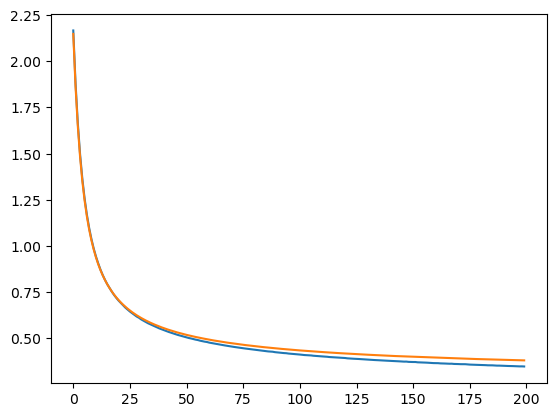

In [48]:
from torch.optim import SGD
from tqdm import tqdm
# optimization hyperparameters
# learning rate
lr = 1e-4 
# total epochs
train_epochs = 200

# optimizer
optimizer = SGD(model.parameters(), lr = lr)
losses = []

for e in tqdm(range(train_epochs)):
    lss = train_epoch(model, dl_train, optimizer, val = ds_val)
    losses.append(lss) 
plt.plot(losses)

### Exercise 3.3: Evaluating our model

Write some code to plot the loss curve for your training run and evaluate the performance of your model on the test data. Play with the hyperparameters (e.g. learning rate) to try to get the best performance on the test set. Can you beat the stable baseline?

In [49]:
preds = np.argmax(model(ds_test.data).detach().numpy(), 1)
print(classification_report(ds_test.targets, preds))

# accuracy is even better at about 90%

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.95      0.96      0.95      1135
           2       0.91      0.86      0.89      1032
           3       0.88      0.89      0.89      1010
           4       0.88      0.92      0.90       982
           5       0.88      0.83      0.86       892
           6       0.92      0.93      0.93       958
           7       0.92      0.90      0.91      1028
           8       0.86      0.86      0.86       974
           9       0.88      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Going Deeper

Now we will go (at least one layer) deeper to see if we can significantly improve on the baseline.

### Exercise 3.4: A 2-layer MLP
Define a new model with one hidden layer. Use the code you wrote above to train and evaluate this new model. Can you beat the baseline? You might need to train in two stages using different learning rates.

**Things to think about**:

+ It might be hard to beat (or even equal) the baseline with deeper networks. Why?
+ Is there something else we should be monitoring while training, especially for deep networks?

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:50<00:00,  1.45s/it]


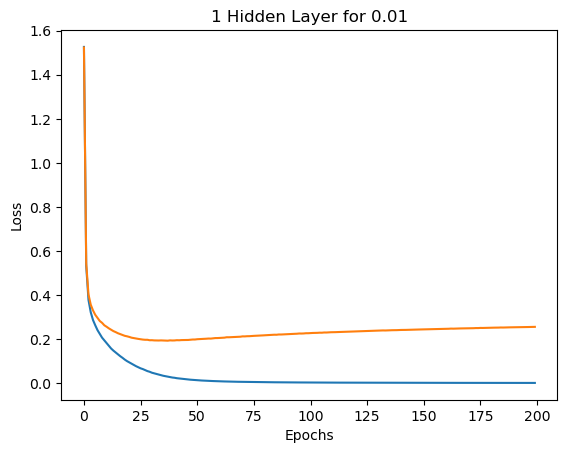

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.92      0.94       892
           6       0.95      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.95      0.92      0.94       974
           9       0.95      0.94      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


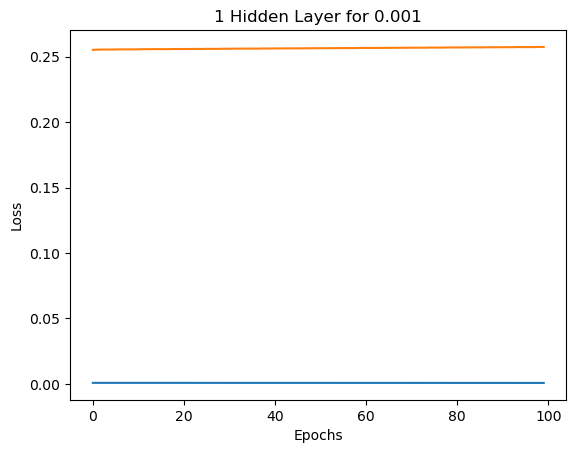

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.92      0.94       892
           6       0.95      0.96      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.95      0.92      0.93       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.77s/it]


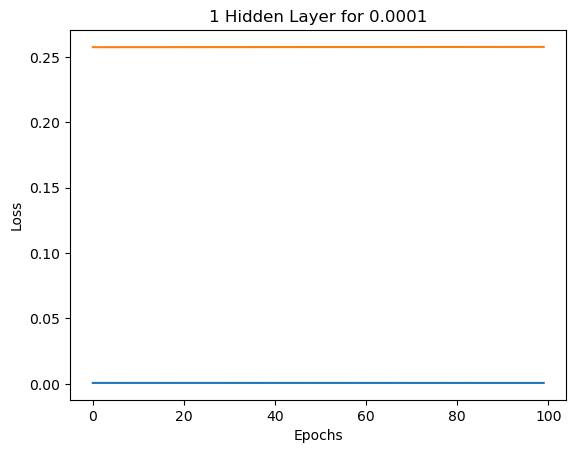

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.92      0.94       892
           6       0.95      0.96      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.95      0.92      0.93       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [58]:
# Define a fresh model.
def deepTraining(learn_rate, train_ep, modelDeep):
    lr = learn_rate
    train_epochs = train_ep
    optimizer = SGD(modelDeep.parameters(), lr = lr)
    losses = []
    for e in tqdm(range(train_epochs)):
        lss = train_epoch(modelDeep, dl_train, optimizer, val = ds_val)
        losses.append(lss) 
    plt.title("1 Hidden Layer for "+str(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(losses)
    plt.show()
    preds = np.argmax(modelDeep(ds_test.data).detach().numpy(), 1)
    print(classification_report(ds_test.targets, preds))
    
modelDeep = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10),
    torch.nn.LogSoftmax(dim = 1)
)
deepTraining(1e-2, 200, modelDeep)
deepTraining(1e-3, 100, modelDeep)
deepTraining(1e-4, 100, modelDeep)

We can try a succession of training not starting from scratch every time: 200 epochs with a higher learning rate, decreasing it every 100 epochs afterwards. But it seems that the model starts to overfit even before getting to the 100th epoch. Model performance is not getting much better with one hidden layer compared to that of in exercise 3.2a. After 200 epochs it seems that the model can not learn more and it can't improve the accuracy to more than 95%.

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:27<00:00,  2.24s/it]


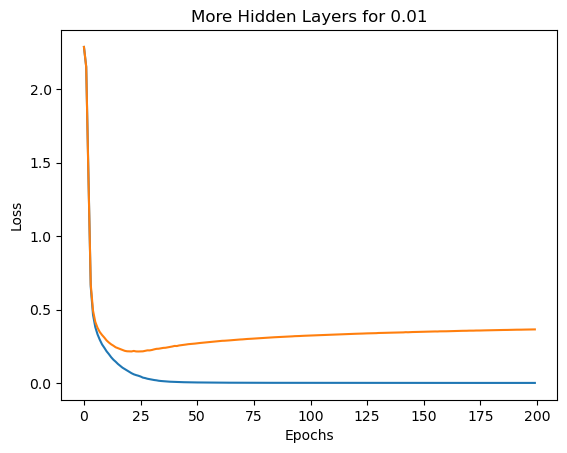

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.95      0.94      1010
           4       0.95      0.96      0.95       982
           5       0.94      0.92      0.93       892
           6       0.94      0.96      0.95       958
           7       0.95      0.95      0.95      1028
           8       0.95      0.92      0.93       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.94s/it]


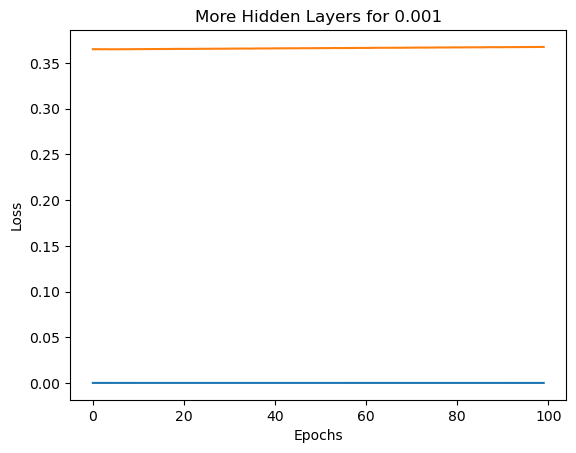

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.95      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.94      0.92      0.93       892
           6       0.94      0.96      0.95       958
           7       0.95      0.95      0.95      1028
           8       0.95      0.92      0.93       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:15<00:00,  1.96s/it]


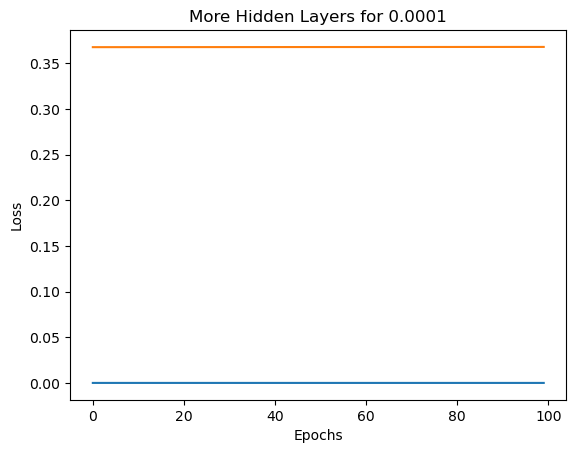

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.95      0.94      1010
           4       0.95      0.96      0.96       982
           5       0.94      0.92      0.93       892
           6       0.94      0.96      0.95       958
           7       0.95      0.95      0.95      1028
           8       0.95      0.92      0.93       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [59]:
def deeperTraining(learn_rate, train_ep, modelDeeper):
    lr = learn_rate
    train_epochs = train_ep
    optimizer = SGD(modelDeeper.parameters(), lr = lr)
    losses = []
    for e in tqdm(range(train_epochs)):
        lss = train_epoch(modelDeeper, dl_train, optimizer, val = ds_val)
        losses.append(lss) 
    plt.title("More Hidden Layers for "+str(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(losses)
    plt.show()
    preds = np.argmax(modelDeeper(ds_test.data).detach().numpy(), 1)
    print(classification_report(ds_test.targets, preds))
    
modelDeeper = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10),
    torch.nn.LogSoftmax(dim = 1)
)
deeperTraining(1e-2, 200, modelDeeper)
deeperTraining(1e-3, 100, modelDeeper)
deeperTraining(1e-4, 100, modelDeeper)

With more hidden layers we get about the same accuracy but it overfits earlier.

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [09:31<00:00,  1.43s/it]


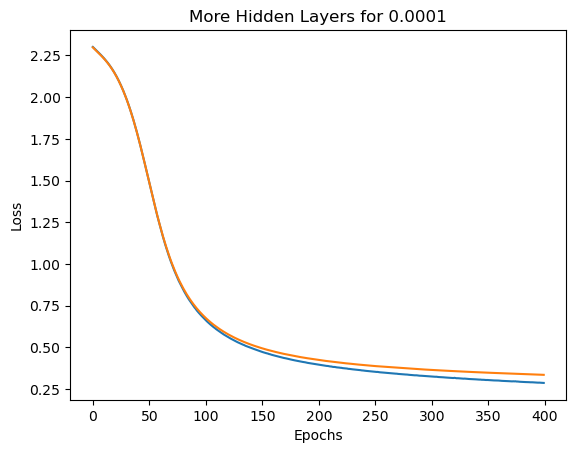

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.90      0.88      0.89      1032
           3       0.88      0.90      0.89      1010
           4       0.88      0.92      0.90       982
           5       0.88      0.83      0.86       892
           6       0.93      0.93      0.93       958
           7       0.91      0.90      0.91      1028
           8       0.89      0.86      0.87       974
           9       0.89      0.86      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000



In [61]:
modelDeep = torch.nn.Sequential(
    # 1 input, 100 outputs
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10),
    torch.nn.LogSoftmax(dim = 1)
)
deepTraining(1e-4, 400, modelDeep)


If we train with lr=1e-4 over 400 epochs we dont overfit but the converging to a better model is very slow.